In [1]:
import gym
import gym_examples
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
env = gym.make('gym_examples/GridWorld-v0', size=4)

In [3]:
state_size = 16
action_size = 4

In [4]:
print(state_size)

16


In [5]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)

policy = Policy()

In [6]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(policy.parameters(), lr=0.03)

# Define the update policy function
# def update_policy(rewards, log_probs, optimizer):
#     log_probs = torch.stack(log_probs)
#     loss = -torch.mean(log_probs) * (sum(rewards) - 15)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

def update_policy(rewards, log_probs, optimizer):
    R = 0
    policy_loss = []
    returns = []
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Normalize returns
    for log_prob, R in zip(log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()


gamma = 0.99


In [7]:
import matplotlib.pyplot as plt

Run 1/10 completed.
Run 2/10 completed.
Run 3/10 completed.
Run 4/10 completed.
Run 5/10 completed.
Run 6/10 completed.
Run 7/10 completed.
Run 8/10 completed.
Run 9/10 completed.
Run 10/10 completed.


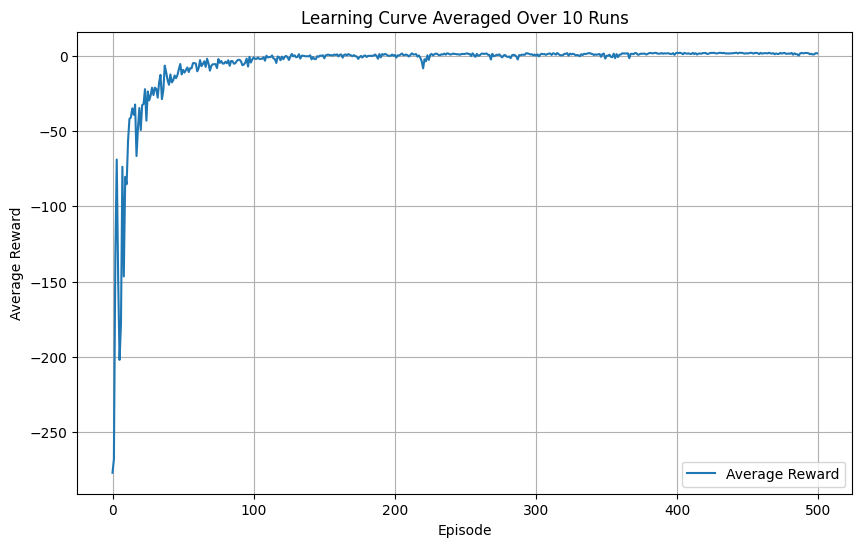

In [17]:
num_runs = 10
num_episodes = 500

# Initialize the scores array to store scores from all runs
scores = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)    
    policy = Policy()  # Initialize your policy
    optimizer = optim.Adam(policy.parameters(), lr=0.01)

    for episode in range(num_episodes):
        # Reset the environment and variables at the start of each episode
        state = env.reset()[0]['agent']
        score = 0
        done = False

        log_probs = []
        rewards = []

        while not done:
            state = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            probs = policy(state)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[:, action])

            # Take step
            next_state, reward, done, _, _ = env.step(action)
            next_state = next_state['agent']
            score += reward

            rewards.append(reward)
            log_probs.append(log_prob)
            state = next_state

        scores[run, episode] = score
        update_policy(rewards, log_probs, optimizer)  # Update the policy

    print(f"Run {run+1}/{num_runs} completed.")

# Calculate the average score across all runs for each episode
average_scores = np.mean(scores, axis=0)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(average_scores, label='Average Reward')
plt.title("Learning Curve Averaged Over 10 Runs")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Training loop
for episode in range(500):
    state = env.reset()[0]['agent']
    score = 0
    done = False

    log_probs = []
    rewards = []
    
    while not done:
        state = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
        probs = policy(state)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[:, action])



        next_state, reward, done, _, _ = env.step(action)
        next_state = next_state['agent']
        score += reward
        
        rewards.append(reward)
        log_probs.append(log_prob)
        state = next_state


    print(f"Episode {episode}: {score}")
    update_policy(rewards, log_probs, optimizer)

/Users/andyyang/Desktop/DS598 Reinforcement Learning/gym-examples/.env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0: -182
Episode 1: -339
Episode 2: -185
Episode 3: -59
Episode 4: -81
Episode 5: -76
Episode 6: -276
Episode 7: -202
Episode 8: -64
Episode 9: -86
Episode 10: -57
Episode 11: -83
Episode 12: -33
Episode 13: -28
Episode 14: -130
Episode 15: -4
Episode 16: -135
Episode 17: -43
Episode 18: -34
Episode 19: -29
Episode 20: -10
Episode 21: -8
Episode 22: -1
Episode 23: -8
Episode 24: -23
Episode 25: -18
Episode 26: -8
Episode 27: -3
Episode 28: -12
Episode 29: -7
Episode 30: -3
Episode 31: -7
Episode 32: -2
Episode 33: -70
Episode 34: -5
Episode 35: -10
Episode 36: -34
Episode 37: -22
Episode 38: -5
Episode 39: -56
Episode 40: -19
Episode 41: -15
Episode 42: -5
Episode 43: -14
Episode 44: -9
Episode 45: -9
Episode 46: -18
Episode 47: -25
Episode 48: -28
Episode 49: -20
Episode 50: -1
Episode 51: -2
Episode 52: -12
Episode 53: -6
Episode 54: -16
Episode 55: -7
Episode 56: -30
Episode 57: -19
Episode 58: -48
Episode 59: -25
Episode 60: -17
Episode 61: -1
Episode 62: -46
Episode 63: -5


# Pt 2, plotting with Vstar function as baseline

Episode 0, Score: -91
Episode 100, Score: -1
Episode 200, Score: 2
Episode 300, Score: 2
Episode 400, Score: 2


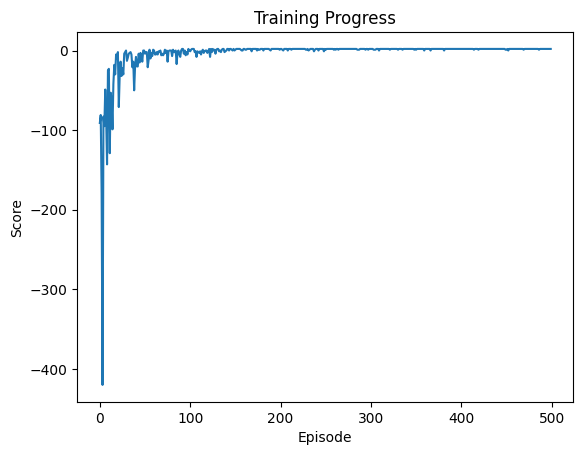

In [13]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming you're using a custom environment, replace 'YourCustomEnvID' with its ID
env = gym.make('gym_examples/GridWorld-v0', size=4)

# state_size = env.observation_space.shape[0]
# action_size = env.action_space.n

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

policy = Policy()
value_network = ValueNetwork()

optimizer = optim.Adam(policy.parameters(), lr=0.01)
value_optimizer = optim.Adam(value_network.parameters(), lr=0.01)

def update_policy_and_value_network(states, rewards, log_probs, gamma=0.99):
    R = 0
    returns = []
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    values = value_network(states)
    values = values.squeeze()
    advantages = returns - values.detach()

    policy_loss = []
    for log_prob, advantage in zip(log_probs, advantages):
        policy_loss.append(-log_prob * advantage)
    policy_loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    value_loss = F.mse_loss(values, returns)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

num_episodes = 500
scores = []


for episode in range(num_episodes):
    state = env.reset()[0]['agent']
    done = False
    score = 0
    log_probs = []
    rewards = []
    states = []

    while not done:
        state = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
        states.append(state)
        probs = policy(state)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[:, action])

        next_state, reward, done, _, _ = env.step(action)
        next_state = next_state['agent']
        score += reward

        rewards.append(reward)
        log_probs.append(log_prob)

        state = next_state

    scores.append(score)
    update_policy_and_value_network(torch.cat(states), rewards, log_probs)


    if episode % 100 == 0:
        print(f"Episode {episode}, Score: {score}")

# Plotting
plt.plot(scores)
plt.title('Training Progress')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()


Run 1, Episode 100, Score: 0
Run 1, Episode 200, Score: 1
Run 1, Episode 300, Score: 2
Run 1, Episode 400, Score: 2
Run 1, Episode 500, Score: 2
Run 2, Episode 100, Score: 1
Run 2, Episode 200, Score: 2
Run 2, Episode 300, Score: 2
Run 2, Episode 400, Score: 2
Run 2, Episode 500, Score: 2
Run 3, Episode 100, Score: -2
Run 3, Episode 200, Score: 2
Run 3, Episode 300, Score: 2
Run 3, Episode 400, Score: 0
Run 3, Episode 500, Score: 2
Run 4, Episode 100, Score: 2
Run 4, Episode 200, Score: 2
Run 4, Episode 300, Score: 2
Run 4, Episode 400, Score: 2
Run 4, Episode 500, Score: 2
Run 5, Episode 100, Score: 2
Run 5, Episode 200, Score: 2
Run 5, Episode 300, Score: 2
Run 5, Episode 400, Score: 2
Run 5, Episode 500, Score: 2
Run 6, Episode 100, Score: 1
Run 6, Episode 200, Score: 1
Run 6, Episode 300, Score: 2
Run 6, Episode 400, Score: 2
Run 6, Episode 500, Score: 2
Run 7, Episode 100, Score: -4
Run 7, Episode 200, Score: 1
Run 7, Episode 300, Score: 0
Run 7, Episode 400, Score: 0
Run 7, Episo

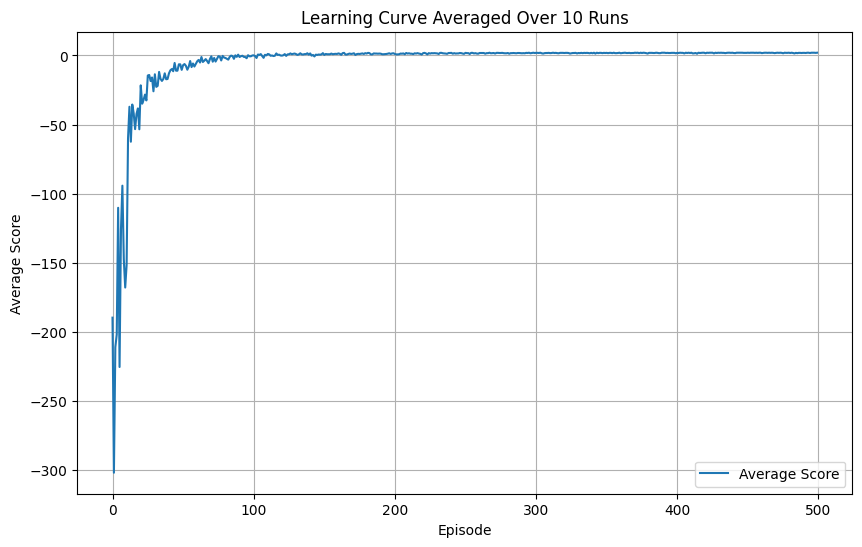

In [20]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming you're using a custom environment, replace 'YourCustomEnvID' with its ID
env = gym.make('gym_examples/GridWorld-v0', size=4)

state_size = 16
action_size = 4

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def update_policy_and_value_network(states, rewards, log_probs, gamma=0.99):
    R = 0
    returns = []
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    values = value_network(states)
    values = values.squeeze()
    advantages = returns - values.detach()

    policy_loss = []
    for log_prob, advantage in zip(log_probs, advantages):
        policy_loss.append(-log_prob * advantage)
    policy_loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    value_loss = F.mse_loss(values, returns)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

num_runs = 10
num_episodes = 500
scores = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    policy = Policy()
    value_network = ValueNetwork()
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    value_optimizer = optim.Adam(value_network.parameters(), lr=0.01)

    for episode in range(num_episodes):
        state = env.reset()[0]['agent']
        done = False
        score = 0
        log_probs = []
        rewards = []
        states = []

        while not done:
            state = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            states.append(state)
            probs = policy(state)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[:, action])

            next_state, reward, done, _, _ = env.step(action)
            next_state = next_state['agent']
            score += reward

            rewards.append(reward)
            log_probs.append(log_prob)

            state = next_state

        scores[run, episode] = score
        update_policy_and_value_network(torch.cat(states), rewards, log_probs)

        if (episode + 1) % 100 == 0:
            print(f"Run {run + 1}, Episode {episode + 1}, Score: {score}")

# Calculate the average score across all runs for each episode
average_scores = np.mean(scores, axis=0)

# Plotting the learning curve averaged over runs
plt.figure(figsize=(10, 6))
plt.plot(average_scores, label='Average Score')
plt.title("Learning Curve Averaged Over 10 Runs")
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.legend()
plt.grid(True)
plt.show()
